#CIBMTR - Equity in post-HCT Survival Predictions

**Description**

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups. By using synthetic data—which mirrors real-world situations while protecting patient privacy—participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions. The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups. Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

**Evaluation**

Evaluation Criteria
The evaluation of prediction accuracy in the competition will involve a specialized metric known as the Stratified Concordance Index (C-index), adapted to consider different racial groups independently. This method allows us to gauge the predictive performance of models in a way that emphasizes equitability across diverse patient populations, particularly focusing on racial disparities in transplant outcomes.

Concordance index
It represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. It can be computed with the following formula:
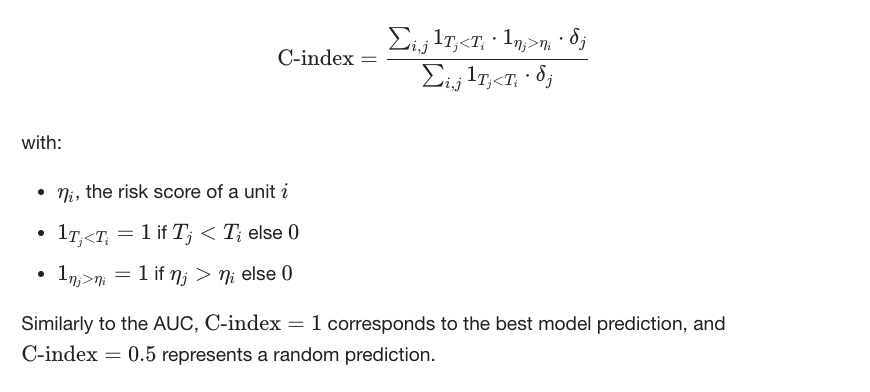


The concordance index is a value between 0 and 1 where:

0.5 is the expected result from random predictions,
1.0 is a perfect concordance and,
0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
Stratified Concordance Index
For this competition, we adjust the standard C-index to account for racial stratification, thus ensuring that each racial group's outcomes are weighed equally in the model evaluation. The stratified c-index is calculated as the mean minus the standard deviation of the c-index scores calculated within the recipient race categories, i.e., the score will be better if the mean c-index over the different race categories is large and the standard deviation of the c-indices over the race categories is small. This value will range from 0 to 1, 1 is the theoretical perfect score, but this value will practically be lower due to censored outcomes.

The submitted risk scores will be evaluated using the score function. This evaluation process involves comparing the submitted risk scores against actual observed values (i.e., survival times and event occurrences) from a test dataset. The function specifically calculates the stratified concordance index across different racial groups, ensuring that the predictions are not only accurate overall but also equitable across diverse patient demographics.

The implementation of the metric is wound in this notebook.
Submission File
Participants must submit their predictions for the test dataset as real-valued risk scores. These scores represent the model's assessment of each patient's risk following transplantation. A higher risk score typically indicates a higher likelihood of the target event occurrence.

The submission file must include a header and follow this format:

ID,prediction
28800,0.5
28801,1.2
28802,0.8
etc.
where:

ID refers to the identifier for each patient in the test dataset.
prediction is the corresponding risk score generated by your model.

****

In [86]:
#@title Import files
! sudo apt-get install python3-setuptools
! pip install numpy pandas scikit-learn xgboost scikit-survival ace_tools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from scipy.stats import mode
from scipy.stats import f_oneway




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-setuptools is already the newest version (59.6.0-1.2ubuntu0.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [430]:
#@title Load dataset
data_path = "train.csv"
data = pd.read_csv(data_path)
# Fix column names

data.columns = data.columns.str.strip()

print(data.shape)



# Load dataset
data_path = "train.csv"
df = pd.read_csv(data_path)
# Fix column names
df.columns = df.columns.str.strip()


print(df.shape)

missing_summary = df.isnull().sum().sum() * 100 / df.size
print(f"Total missing data: {missing_summary:.2f}%")


(28800, 60)
(28800, 60)
Total missing data: 10.97%


#**DATA PREPROCESSING**



In [431]:
#Dropping unnecessary columns

df = df.drop(columns=['ID','year_hct'])

##Total data preprocessing predefined functions

In [432]:
""" preprocessing functions """
def print_column_info(df, column_name):
    total_values = df[column_name].count()  # Non-NaN values
    missing_values = df[column_name].isna().sum()  # NaN values
    total_entries = len(df[column_name])  # Total rows in column

    print(f"Column: {column_name}")
    print(f"Total Entries: {total_entries}")
    print(f"Non-NaN Values: {total_values}")
    print(f"Missing (NaN) Values: {missing_values}")
    print(f"Missing (NaN) Values %: {(missing_values/28800)*100}")
    print("Unique_values:",df[column_name].unique())

# Example usage
#print_column_info(df, "karnofsky_score")

def drop_rows_with_missing_threshold(df, threshold=0.5):
    """
    Drops rows where the percentage of missing values is greater than a given threshold.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The fraction of missing values (default = 0.5 for 50%).

    Returns:
    pd.DataFrame: A new DataFrame with rows removed.
    """
    missing_fraction = df.isna().sum(axis=1) / df.shape[1]  # Calculate % of missing values per row
    df_cleaned = df[missing_fraction <= threshold]  # Keep rows where missing % is ≤ threshold
    return df_cleaned

def count_rows_with_missing_threshold(df, threshold):
    """
    Counts the number of rows where the percentage of missing values is greater than a given threshold.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The fraction of missing values (default = 0.5 for 50%).

    Returns:
    int: The number of rows with more than threshold% missing values.
    """
    missing_fraction = df.isna().sum(axis=1) / df.shape[1]  # Calculate % of missing values per row
    count = (missing_fraction > threshold).sum()  # Count rows exceeding threshold
    return count


threshold=0.3
print('count_rows_with_missing_threshold:',count_rows_with_missing_threshold(df,threshold))
#df = drop_rows_with_missing_threshold(df, threshold)

def columns_with_missing_threshold(df, threshold=30):
    """
    Lists columns where the percentage of missing values exceeds a given threshold.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The missing value percentage threshold (default = 30%).

    Returns:
    pd.Series: Columns and their missing percentage.
    """
    missing_percent = df.isnull().sum() * 100 / len(df)
    missing_above_threshold = missing_percent[missing_percent > threshold]

    return missing_above_threshold.sort_values(ascending=False)

# Example usage:
threshold = -1
 # Set threshold to 30%
missing_columns = columns_with_missing_threshold(df, threshold)

print(f"Columns with more than {threshold}% missing values:")
print(missing_columns)

df.shape

count_rows_with_missing_threshold: 3179
Columns with more than -1% missing values:
tce_match                 65.958333
mrd_hct                   57.628472
cyto_score_detail         41.399306
tce_div_match             39.569444
tce_imm_match             38.656250
cyto_score                28.013889
hla_high_res_10           24.871528
hla_high_res_8            20.239583
hla_high_res_6            18.347222
hla_match_dqb1_high       18.052083
hla_low_res_10            17.583333
conditioning_intensity    16.628472
hla_match_c_high          16.041667
hla_match_a_high          14.934028
hla_nmdp_6                14.572917
hla_match_dqb1_low        14.562500
hla_match_b_high          14.194444
hla_low_res_8             12.684028
hla_match_drb1_high       11.638889
hla_low_res_6             11.354167
hla_match_c_low            9.722222
hla_match_drb1_low         9.177083
hla_match_b_low            8.906250
cardiac                    8.826389
peptic_ulcer               8.399306
hla_match_a_low  

(28800, 58)

In [433]:
print_column_info(df,'tbi_status')


Column: tbi_status
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['No TBI' 'TBI +- Other, >cGy' 'TBI + Cy +- Other' 'TBI +- Other, <=cGy'
 'TBI +- Other, unknown dose' 'TBI +- Other, -cGy, fractionated'
 'TBI +- Other, -cGy, single' 'TBI +- Other, -cGy, unknown dose']


### Predefined Functions

In [434]:


import pandas as pd
import numpy as np
from scipy.stats import f_oneway

def impute_missing_with_mean_efs(df, categorical_col, target_col="efs_time"):

    # Ensure the column exists
    if categorical_col not in df.columns:
        print(f"⚠️ Warning: Column '{categorical_col}' not found. Skipping...")
        return df, None

    print(f"\n🔹 Processing Column: {categorical_col}")

    # Step 1: Compute mean `efs_time` for each category
    mean_efs_time = df.groupby(categorical_col)[target_col].mean()
    print(f"\n📊 Mean `{target_col}` for each `{categorical_col}` category:\n{mean_efs_time}")

    # Step 2: Assign NaN values based on closest mean `efs_time`
    def assign_closest_category(row):
        if pd.isna(row[categorical_col]):
            closest_match = min(mean_efs_time.keys(), key=lambda x: abs(mean_efs_time[x] - row[target_col]))
            return closest_match
        return row[categorical_col]

    df[f"{categorical_col}_mean"] = df.apply(assign_closest_category, axis=1)



    # Step 3: Perform ANOVA test
    unique_categories = df[f"{categorical_col}_mean"].unique()
    groups = [df[df[f"{categorical_col}_mean"] == category][target_col] for category in unique_categories if not np.isnan(category)]

    if len(groups) > 1:
        f_stat, p_value = f_oneway(*groups)
        anova_result = {"F-statistic": f_stat, "p-value": p_value}
        print(f"\n📈 ANOVA Results: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
        return f_stat
    else:
        anova_result = {"F-statistic": np.nan, "p-value": np.nan}
        print("\n⚠️ Not enough categories for ANOVA test.")



def impute_missing_with_median_efs(df, categorical_col, target_col="efs_time"):

    # Ensure the column exists
    if categorical_col not in df.columns:
        print(f"⚠️ Warning: Column '{categorical_col}' not found. Skipping...")
        return df, None

    print(f"\n🔹 Processing Column: {categorical_col}")

    # Step 1: Compute median `efs_time` for each category
    median_efs_time = df.groupby(categorical_col)[target_col].median()
    print(f"\n📊 Median `{target_col}` for each `{categorical_col}` category:\n{median_efs_time}")

    # Step 2: Assign NaN values based on closest median `efs_time`
    def assign_closest_category(row):
        if pd.isna(row[categorical_col]):
            closest_match = min(median_efs_time.keys(), key=lambda x: abs(median_efs_time[x] - row[target_col]))
            return closest_match
        return row[categorical_col]

    df[f"{categorical_col}_median"] = df.apply(assign_closest_category, axis=1)

    # Step 3: Perform ANOVA test
    unique_categories = df[f"{categorical_col}_median"].unique()
    groups = [df[df[f"{categorical_col}_median"] == category][target_col] for category in unique_categories if not np.isnan(category)]

    if len(groups) > 1:
        f_stat, p_value = f_oneway(*groups)
        anova_result = {"F-statistic": f_stat, "p-value": p_value}
        print(f"\n📈 ANOVA Results: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
        return f_stat
    else:
        anova_result = {"F-statistic": np.nan, "p-value": np.nan}
        print("\n⚠️ Not enough categories for ANOVA test.")


def impute_missing_with_mode_efs(df, categorical_col, target_col="efs_time"):

    # Ensure the column exists
    if categorical_col not in df.columns:
        print(f"⚠️ Warning: Column '{categorical_col}' not found. Skipping...")
        return df, None

    print(f"\n🔹 Processing Column: {categorical_col}")

    # Step 1: Compute mode `efs_time` for each category
    mode_efs_time = df.groupby(categorical_col)[target_col].agg(lambda x: mode(x.dropna(), keepdims=True).mode[0])
    print(f"\n📊 Mode `{target_col}` for each `{categorical_col}` category:\n{mode_efs_time}")

    # Step 2: Assign NaN values based on closest mode `efs_time`
    def assign_closest_category(row):
        if pd.isna(row[categorical_col]):
            closest_match = min(mode_efs_time.keys(), key=lambda x: abs(mode_efs_time[x] - row[target_col]))
            return closest_match
        return row[categorical_col]

    df[f"{categorical_col}_mode"] = df.apply(assign_closest_category, axis=1)

    # Step 3: Perform ANOVA test
    unique_categories = df[f"{categorical_col}_mode"].unique()
    groups = [df[df[f"{categorical_col}_mode"] == category][target_col] for category in unique_categories if not np.isnan(category)]

    if len(groups) > 1:
        f_stat, p_value = f_oneway(*groups)
        anova_result = {"F-statistic": f_stat, "p-value": p_value}
        print(f"\n📈 ANOVA Results: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
        return f_stat
    else:
        anova_result = {"F-statistic": np.nan, "p-value": np.nan}
        print("\n⚠️ Not enough categories for ANOVA test.")

def ordinal_central_imputation(df,attribute):
  f_stat_mean=impute_missing_with_mean_efs(df, attribute) # will add hla_low_res_6_mean
  f_stat_median=impute_missing_with_median_efs(df, attribute) # will add hla_low_res_6_median
  f_stat_mode=impute_missing_with_mode_efs(df, attribute) # will add hla_low_res_6_mode

  print(f_stat_mean,f_stat_median,f_stat_mode)


  if f_stat_mean>f_stat_median and f_stat_mean>f_stat_mode:
    print(attribute+" is imputed with mean !")
    df.drop(columns=[attribute],inplace=True)
    df.drop(columns=[attribute+'_median'],inplace=True)
    df.drop(columns=[attribute+'_mode'],inplace=True)
    df.rename(columns={attribute+'_mean': attribute}, inplace=True)


  elif f_stat_median>f_stat_mean and f_stat_median>f_stat_mode:
    print(attribute+" is imputed with median !")
    df.drop(columns=[attribute],inplace=True)
    df.drop(columns=[attribute+'_mean'],inplace=True)
    df.drop(columns=[attribute+'_mode'],inplace=True)
    df.rename(columns={attribute+'_median': attribute}, inplace=True)

  else:
    print(attribute+" is imputed with mode !")
    df.drop(columns=[attribute],inplace=True)
    df.drop(columns=[attribute+'_mean'],inplace=True)
    df.drop(columns=[attribute+'_median'],inplace=True)
    df.rename(columns={attribute+'_mode': attribute}, inplace=True)
  return df


def value_percentage(df, column):
    """
    Computes the percentage of each unique value in a specified column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column to analyze.

    Returns:
    pd.DataFrame: A DataFrame showing each unique value and its percentage.
    """
    if column not in df.columns:
        print(f"⚠️ Warning: Column '{column}' not found in DataFrame.")
        return None

    value_counts = df[column].value_counts(dropna=False)  # Include NaNs
    total = len(df)  # Total number of entries
    percentage = (value_counts / total) * 100  # Compute percentage

    result = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percentage.values})

    return result.sort_values(by="Percentage", ascending=False)


#ordinal_central_imputation(df,'hla_low_res_6')
#print(df.shape)
#df['hla_low_res_6_mean']





## Ordinal Columns Imputation with no category (Generalized with mean median and mode)

### HLA_LOW_RES_6

In [435]:
ordinal_central_imputation(df,'hla_low_res_6') #HLA_LOW_RES_6


🔹 Processing Column: hla_low_res_6

📊 Mean `efs_time` for each `hla_low_res_6` category:
hla_low_res_6
2.0    18.233273
3.0    21.218795
4.0    23.470514
5.0    23.510732
6.0    23.466899
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 347.4041, p-value = 0.0000

🔹 Processing Column: hla_low_res_6

📊 Median `efs_time` for each `hla_low_res_6` category:
hla_low_res_6
2.0    13.762
3.0    10.938
4.0    12.814
5.0    11.301
6.0     9.075
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 334.5392, p-value = 0.0000

🔹 Processing Column: hla_low_res_6

📊 Mode `efs_time` for each `hla_low_res_6` category:
hla_low_res_6
2.0    3.559
3.0    2.783
4.0    3.524
5.0    4.603
6.0    5.697
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 35.9053, p-value = 0.0000
347.40414479680646 334.5391571564707 35.90529245642989
hla_low_res_6 is imputed with mean !


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,graft_type,vent_hist,...,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,hla_low_res_6
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,Bone marrow,No,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,6.0
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,Peripheral blood,No,...,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,6.0
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,Bone marrow,No,...,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,6.0
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,Bone marrow,No,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,6.0
4,High,No,NaN,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633,6.0
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,Peripheral blood,No,...,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892,5.0
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,Peripheral blood,No,...,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157,6.0
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,Peripheral blood,No,...,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351,3.0


### HLA_LOW_RES_8

In [436]:
ordinal_central_imputation(df,'hla_low_res_8') #HLA_LOW_RES_8


🔹 Processing Column: hla_low_res_8

📊 Mean `efs_time` for each `hla_low_res_8` category:
hla_low_res_8
2.0    11.129000
3.0    27.804870
4.0    20.678712
5.0    23.297507
6.0    23.093081
7.0    23.702201
8.0    23.549949
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 522.0632, p-value = 0.0000

🔹 Processing Column: hla_low_res_8

📊 Median `efs_time` for each `hla_low_res_8` category:
hla_low_res_8
2.0    11.1290
3.0    17.3440
4.0    10.2870
5.0    12.6970
6.0    11.8695
7.0    11.4410
8.0     9.0990
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 267.9745, p-value = 0.0000

🔹 Processing Column: hla_low_res_8

📊 Mode `efs_time` for each `hla_low_res_8` category:
hla_low_res_8
2.0    11.129
3.0     3.559
4.0     2.783
5.0     1.542
6.0     3.524
7.0     4.603
8.0     5.229
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 157.4596, p-value = 0.0000
522.063189870485 267.9745123026222 157.45955371588437
hla_low_res_8 is imputed with mean !


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,graft_type,vent_hist,...,donor_related,melphalan_dose,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,hla_low_res_6,hla_low_res_8
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,Bone marrow,No,...,Unrelated,"N/A, Mel not given",No,2.0,No,10.0,0.0,42.356,6.0,8.0
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,Peripheral blood,No,...,Related,"N/A, Mel not given",No,2.0,Yes,10.0,1.0,4.672,6.0,8.0
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,Bone marrow,No,...,Related,"N/A, Mel not given",No,2.0,No,10.0,0.0,19.793,6.0,8.0
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,Bone marrow,No,...,Unrelated,"N/A, Mel not given",No,2.0,No,10.0,0.0,102.349,6.0,8.0
4,High,No,NaN,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,Related,MEL,No,2.0,No,10.0,0.0,16.223,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,NaN,"N/A, Mel not given",NaN,2.0,No,10.0,0.0,18.633,6.0,8.0
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,Peripheral blood,No,...,Related,"N/A, Mel not given",Yes,1.0,Yes,8.0,1.0,4.892,5.0,6.0
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,Peripheral blood,No,...,Unrelated,"N/A, Mel not given",NaN,2.0,No,10.0,0.0,23.157,6.0,8.0
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,Peripheral blood,No,...,Related,MEL,No,1.0,No,5.0,0.0,52.351,3.0,4.0


### HLA_LOW_RES_10

In [437]:
ordinal_central_imputation(df,'hla_low_res_10') #HLA_LOW_RES_10


🔹 Processing Column: hla_low_res_10

📊 Mean `efs_time` for each `hla_low_res_10` category:
hla_low_res_10
4.0     22.124731
5.0     20.383799
6.0     23.087972
7.0     22.800768
8.0     23.129648
9.0     23.384179
10.0    23.446296
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 213.4604, p-value = 0.0000

🔹 Processing Column: hla_low_res_10

📊 Median `efs_time` for each `hla_low_res_10` category:
hla_low_res_10
4.0     13.2995
5.0     10.3350
6.0     14.8620
7.0     11.6730
8.0     11.9770
9.0     10.6555
10.0     9.0565
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 252.0676, p-value = 0.0000

🔹 Processing Column: hla_low_res_10

📊 Mode `efs_time` for each `hla_low_res_10` category:
hla_low_res_10
4.0     2.931
5.0     3.413
6.0     4.999
7.0     1.542
8.0     3.524
9.0     5.679
10.0    5.643
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 74.3242, p-value = 0.0000
213.46040138010827 252.0676020277225 74.32416789355112
hla_low_res_10 is

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,graft_type,vent_hist,...,donor_related,melphalan_dose,cardiac,hla_match_drb1_high,pulm_moderate,efs,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,Bone marrow,No,...,Unrelated,"N/A, Mel not given",No,2.0,No,0.0,42.356,6.0,8.0,10.0
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,Peripheral blood,No,...,Related,"N/A, Mel not given",No,2.0,Yes,1.0,4.672,6.0,8.0,10.0
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,Bone marrow,No,...,Related,"N/A, Mel not given",No,2.0,No,0.0,19.793,6.0,8.0,10.0
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,Bone marrow,No,...,Unrelated,"N/A, Mel not given",No,2.0,No,0.0,102.349,6.0,8.0,10.0
4,High,No,NaN,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,Related,MEL,No,2.0,No,0.0,16.223,6.0,8.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,NaN,"N/A, Mel not given",NaN,2.0,No,0.0,18.633,6.0,8.0,10.0
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,Peripheral blood,No,...,Related,"N/A, Mel not given",Yes,1.0,Yes,1.0,4.892,5.0,6.0,8.0
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,Peripheral blood,No,...,Unrelated,"N/A, Mel not given",NaN,2.0,No,0.0,23.157,6.0,8.0,10.0
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,Peripheral blood,No,...,Related,MEL,No,1.0,No,0.0,52.351,3.0,4.0,5.0


### HLA_HIGH_RES_6

In [438]:
ordinal_central_imputation(df,'hla_high_res_6') #HLA_HIGH_RES_6


🔹 Processing Column: hla_high_res_6

📊 Mean `efs_time` for each `hla_high_res_6` category:
hla_high_res_6
0.0    21.476000
2.0    31.504326
3.0    20.981260
4.0    22.404840
5.0    23.843146
6.0    23.433675
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 854.9127, p-value = 0.0000

🔹 Processing Column: hla_high_res_6

📊 Median `efs_time` for each `hla_high_res_6` category:
hla_high_res_6
0.0    21.4760
2.0    18.9160
3.0    11.1855
4.0    11.1885
5.0    10.3435
6.0     9.1890
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 594.2994, p-value = 0.0000

🔹 Processing Column: hla_high_res_6

📊 Mode `efs_time` for each `hla_high_res_6` category:
hla_high_res_6
0.0    21.476
2.0     2.101
3.0     4.585
4.0     4.248
5.0     4.844
6.0     5.643
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 517.4071, p-value = 0.0000
854.9127320539696 594.2993591962048 517.4070622455131
hla_high_res_6 is imputed with mean !


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,graft_type,vent_hist,...,melphalan_dose,cardiac,hla_match_drb1_high,pulm_moderate,efs,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,Bone marrow,No,...,"N/A, Mel not given",No,2.0,No,0.0,42.356,6.0,8.0,10.0,6.0
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,Peripheral blood,No,...,"N/A, Mel not given",No,2.0,Yes,1.0,4.672,6.0,8.0,10.0,6.0
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,Bone marrow,No,...,"N/A, Mel not given",No,2.0,No,0.0,19.793,6.0,8.0,10.0,6.0
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,Bone marrow,No,...,"N/A, Mel not given",No,2.0,No,0.0,102.349,6.0,8.0,10.0,6.0
4,High,No,NaN,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,MEL,No,2.0,No,0.0,16.223,6.0,8.0,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,Peripheral blood,No,...,"N/A, Mel not given",NaN,2.0,No,0.0,18.633,6.0,8.0,10.0,6.0
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,Peripheral blood,No,...,"N/A, Mel not given",Yes,1.0,Yes,1.0,4.892,5.0,6.0,8.0,3.0
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,Peripheral blood,No,...,"N/A, Mel not given",NaN,2.0,No,0.0,23.157,6.0,8.0,10.0,6.0
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,Peripheral blood,No,...,MEL,No,1.0,No,0.0,52.351,3.0,4.0,5.0,3.0


### HLA_HIGH_RES_8

In [439]:
ordinal_central_imputation(df,'hla_high_res_8') #HLA_HIGH_RES_8


🔹 Processing Column: hla_high_res_8

📊 Mean `efs_time` for each `hla_high_res_8` category:
hla_high_res_8
2.0    31.431000
3.0    30.712964
4.0    20.657451
5.0    22.363676
6.0    22.893539
7.0    23.446006
8.0    23.418360
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 890.7311, p-value = 0.0000

🔹 Processing Column: hla_high_res_8

📊 Median `efs_time` for each `hla_high_res_8` category:
hla_high_res_8
2.0    31.4310
3.0    22.7080
4.0    10.9480
5.0    11.8870
6.0    11.6545
7.0     9.9170
8.0     9.1315
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 678.6708, p-value = 0.0000

🔹 Processing Column: hla_high_res_8

📊 Mode `efs_time` for each `hla_high_res_8` category:
hla_high_res_8
2.0    21.476
3.0     2.101
4.0     7.468
5.0     4.853
6.0     1.788
7.0     2.827
8.0     5.643
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 529.9959, p-value = 0.0000
890.731073005236 678.6708498668667 529.9959481391899
hla_high_res_8 is imputed with m

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,...,cardiac,hla_match_drb1_high,pulm_moderate,efs,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8
0,N/A - non-malignant indication,No,NaN,No,NaN,No TBI,No,Bone marrow,No,No,...,No,2.0,No,0.0,42.356,6.0,8.0,10.0,6.0,2.0
1,Intermediate,No,Intermediate,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,...,No,2.0,Yes,1.0,4.672,6.0,8.0,10.0,6.0,8.0
2,N/A - non-malignant indication,No,NaN,No,2.0,No TBI,No,Bone marrow,No,No,...,No,2.0,No,0.0,19.793,6.0,8.0,10.0,6.0,8.0
3,High,No,Intermediate,No,2.0,No TBI,No,Bone marrow,No,No,...,No,2.0,No,0.0,102.349,6.0,8.0,10.0,6.0,8.0
4,High,No,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,...,No,2.0,No,0.0,16.223,6.0,8.0,10.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,No TBI,No,Peripheral blood,No,No,...,NaN,2.0,No,0.0,18.633,6.0,8.0,10.0,6.0,8.0
28796,High,No,Poor,Yes,1.0,No TBI,No,Peripheral blood,No,No,...,Yes,1.0,Yes,1.0,4.892,5.0,6.0,8.0,3.0,4.0
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,...,NaN,2.0,No,0.0,23.157,6.0,8.0,10.0,6.0,8.0
28798,N/A - non-malignant indication,No,Poor,No,1.0,No TBI,No,Peripheral blood,No,NaN,...,No,1.0,No,0.0,52.351,3.0,4.0,5.0,3.0,4.0


### HLA_HIGH_RES_10

In [440]:
ordinal_central_imputation(df,'hla_high_res_10') #HLA_HIGH_RES_10


🔹 Processing Column: hla_high_res_10

📊 Mean `efs_time` for each `hla_high_res_10` category:
hla_high_res_10
3.0     41.386000
4.0     24.235600
5.0     20.615434
6.0     23.012984
7.0     22.140532
8.0     22.611349
9.0     24.057585
10.0    23.229578
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 1066.1293, p-value = 0.0000

🔹 Processing Column: hla_high_res_10

📊 Median `efs_time` for each `hla_high_res_10` category:
hla_high_res_10
3.0     41.3860
4.0     16.6590
5.0     11.6040
6.0     13.4300
7.0     10.9570
8.0     11.8085
9.0     10.0350
10.0     9.0665
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 813.8336, p-value = 0.0000

🔹 Processing Column: hla_high_res_10

📊 Mode `efs_time` for each `hla_high_res_10` category:
hla_high_res_10
3.0     41.386
4.0      2.101
5.0      7.468
6.0      3.822
7.0      2.617
8.0      5.679
9.0      4.844
10.0     5.643
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 779.0476, p-value = 0.0000
1066.

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,...,hla_match_drb1_high,pulm_moderate,efs,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8,hla_high_res_10
0,N/A - non-malignant indication,No,NaN,No,NaN,No TBI,No,Bone marrow,No,No,...,2.0,No,0.0,42.356,6.0,8.0,10.0,6.0,2.0,3.0
1,Intermediate,No,Intermediate,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,...,2.0,Yes,1.0,4.672,6.0,8.0,10.0,6.0,8.0,10.0
2,N/A - non-malignant indication,No,NaN,No,2.0,No TBI,No,Bone marrow,No,No,...,2.0,No,0.0,19.793,6.0,8.0,10.0,6.0,8.0,10.0
3,High,No,Intermediate,No,2.0,No TBI,No,Bone marrow,No,No,...,2.0,No,0.0,102.349,6.0,8.0,10.0,6.0,8.0,10.0
4,High,No,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,...,2.0,No,0.0,16.223,6.0,8.0,10.0,6.0,8.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,No TBI,No,Peripheral blood,No,No,...,2.0,No,0.0,18.633,6.0,8.0,10.0,6.0,8.0,10.0
28796,High,No,Poor,Yes,1.0,No TBI,No,Peripheral blood,No,No,...,1.0,Yes,1.0,4.892,5.0,6.0,8.0,3.0,4.0,6.0
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,...,2.0,No,0.0,23.157,6.0,8.0,10.0,6.0,8.0,10.0
28798,N/A - non-malignant indication,No,Poor,No,1.0,No TBI,No,Peripheral blood,No,NaN,...,1.0,No,0.0,52.351,3.0,4.0,5.0,3.0,4.0,5.0


## Ordinal data with categories missing value Imputation

### DRI_SCORE



<table><thead><tr><th>Original Value</th><th>Consolidated Value</th></tr></thead><tbody><tr><td><code>Intermediate</code></td><td><code>Intermediate</code></td></tr><tr><td><code>High</code></td><td><code>High</code></td></tr><tr><td><code>Low</code></td><td><code>Low</code></td></tr><tr><td><code>Very high</code></td><td><code>Very high</code></td></tr><tr><td><code>N/A - non-malignant indication</code></td><td><code>Non-malignant</code></td></tr><tr><td><code>N/A - pediatric</code></td><td><code>Pediatric</code></td></tr><tr><td><code>N/A - disease not classifiable</code></td><td><code>Unclassifiable</code></td></tr><tr><td><code>TBD cytogenetics</code></td><td><code>Uncertain</code></td></tr><tr><td><code>Intermediate - TED AML case &lt;missing cytogenetics</code></td><td><code>Intermediate - Missing</code></td></tr><tr><td><code>High - TED AML case &lt;missing cytogenetics</code></td><td><code>High - Missing</code></td></tr><tr><td><code>Missing disease status</code>, <code>nan</code></td><td><code>Missing</code></td></tr></tbody></table>

In [441]:



risk_mapping = {
    "Low": 1,
    "Intermediate": 2,
    "High": 3,
    "Very high": 4,
    "N/A - non-malignant indication": 0,
    "N/A - pediatric": 0,
    "N/A - disease not classifiable": 0,
    "TBD cytogenetics": -1,
    "Intermediate - TED AML case <missing cytogenetics": 2,
    "High - TED AML case <missing cytogenetics": 3,
    "Missing disease status": -1,


}

# Apply the mapping to the dri_score column
df['dri_score_encoded'] = df['dri_score'].map(risk_mapping)
df = df.drop(columns=['dri_score']).rename(columns={'dri_score_encoded': 'dri_score'})
print_column_info(df, 'dri_score')
ordinal_central_imputation(df,'dri_score') #dri_score


Column: dri_score
Total Entries: 28800
Non-NaN Values: 28646
Missing (NaN) Values: 154
Missing (NaN) Values %: 0.5347222222222222
Unique_values: [ 0.  2.  3.  1. -1. nan  4.]

🔹 Processing Column: dri_score

📊 Mean `efs_time` for each `dri_score` category:
dri_score
-1.0    26.389308
 0.0    27.021007
 1.0    24.333374
 2.0    22.425626
 3.0    18.569625
 4.0    23.410646
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 96.7833, p-value = 0.0000

🔹 Processing Column: dri_score

📊 Median `efs_time` for each `dri_score` category:
dri_score
-1.0    22.382
 0.0    22.669
 1.0     8.986
 2.0     9.106
 3.0     6.487
 4.0    20.608
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 96.1600, p-value = 0.0000

🔹 Processing Column: dri_score

📊 Mode `efs_time` for each `dri_score` category:
dri_score
-1.0    4.162
 0.0    4.206
 1.0    5.570
 2.0    5.886
 3.0    3.944
 4.0    3.419
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 88.1901, p-value = 0.000

,psych_disturb,cyto_score,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,pulm_moderate,efs,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8,hla_high_res_10,dri_score
0,No,NaN,No,NaN,No TBI,No,Bone marrow,No,No,No,...,No,0.0,42.356,6.0,8.0,10.0,6.0,2.0,3.0,0.0
1,No,Intermediate,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,Yes,1.0,4.672,6.0,8.0,10.0,6.0,8.0,10.0,2.0
2,No,NaN,No,2.0,No TBI,No,Bone marrow,No,No,No,...,No,0.0,19.793,6.0,8.0,10.0,6.0,8.0,10.0,0.0
3,No,Intermediate,No,2.0,No TBI,No,Bone marrow,No,No,No,...,No,0.0,102.349,6.0,8.0,10.0,6.0,8.0,10.0,3.0
4,No,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,No,...,No,0.0,16.223,6.0,8.0,10.0,6.0,8.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,NaN,Favorable,No,2.0,No TBI,No,Peripheral blood,No,No,NaN,...,No,0.0,18.633,6.0,8.0,10.0,6.0,8.0,10.0,2.0
28796,No,Poor,Yes,1.0,No TBI,No,Peripheral blood,No,No,No,...,Yes,1.0,4.892,5.0,6.0,8.0,3.0,4.0,6.0,3.0
28797,NaN,Poor,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,NaN,...,No,0.0,23.157,6.0,8.0,10.0,6.0,8.0,10.0,-1.0
28798,No,Poor,No,1.0,No TBI,No,Peripheral blood,No,NaN,NaN,...,No,0.0,52.351,3.0,4.0,5.0,3.0,4.0,5.0,0.0


###KARNOFSKY_SCORE

In [442]:

# Define ordinal encoding (higher score = better functional status)
karnofsky_mapping = {40: 1, 50: 2, 60: 3, 70: 4, 80: 5, 90: 6, 100: 7}
# Apply encoding

df["karnofsky_encoded"] = df["karnofsky_score"].map(karnofsky_mapping)
df = df.drop(columns=['karnofsky_score']).rename(columns={'karnofsky_encoded': 'karnofsky_score'})
print_column_info(df, 'karnofsky_score')
ordinal_central_imputation(df,'karnofsky_score') #dri_score


Column: karnofsky_score
Total Entries: 28800
Non-NaN Values: 27930
Missing (NaN) Values: 870
Missing (NaN) Values %: 3.0208333333333335
Unique_values: [ 6.  4.  7.  5.  3. nan  2.  1.]

🔹 Processing Column: karnofsky_score

📊 Mean `efs_time` for each `karnofsky_score` category:
karnofsky_score
1.0    16.722000
2.0    23.011099
3.0    16.199071
4.0    20.619745
5.0    18.939793
6.0    25.048464
7.0    25.196491
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 100.2882, p-value = 0.0000

🔹 Processing Column: karnofsky_score

📊 Median `efs_time` for each `karnofsky_score` category:
karnofsky_score
1.0     4.3715
2.0    15.4210
3.0     6.3440
4.0     7.7255
5.0     7.4415
6.0    12.4000
7.0    14.4580
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 128.4659, p-value = 0.0000

🔹 Processing Column: karnofsky_score

📊 Mode `efs_time` for each `karnofsky_score` category:
karnofsky_score
1.0    2.940
2.0    0.711
3.0    3.920
4.0    4.727
5.0    4.181
6.0    5.608
7

,psych_disturb,cyto_score,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,efs,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8,hla_high_res_10,dri_score,karnofsky_score
0,No,NaN,No,NaN,No TBI,No,Bone marrow,No,No,No,...,0.0,42.356,6.0,8.0,10.0,6.0,2.0,3.0,0.0,6.0
1,No,Intermediate,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,1.0,4.672,6.0,8.0,10.0,6.0,8.0,10.0,2.0,6.0
2,No,NaN,No,2.0,No TBI,No,Bone marrow,No,No,No,...,0.0,19.793,6.0,8.0,10.0,6.0,8.0,10.0,0.0,6.0
3,No,Intermediate,No,2.0,No TBI,No,Bone marrow,No,No,No,...,0.0,102.349,6.0,8.0,10.0,6.0,8.0,10.0,3.0,6.0
4,No,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,No,...,0.0,16.223,6.0,8.0,10.0,6.0,8.0,10.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,NaN,Favorable,No,2.0,No TBI,No,Peripheral blood,No,No,NaN,...,0.0,18.633,6.0,8.0,10.0,6.0,8.0,10.0,2.0,2.0
28796,No,Poor,Yes,1.0,No TBI,No,Peripheral blood,No,No,No,...,1.0,4.892,5.0,6.0,8.0,3.0,4.0,6.0,3.0,6.0
28797,NaN,Poor,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,NaN,...,0.0,23.157,6.0,8.0,10.0,6.0,8.0,10.0,-1.0,6.0
28798,No,Poor,No,1.0,No TBI,No,Peripheral blood,No,NaN,NaN,...,0.0,52.351,3.0,4.0,5.0,3.0,4.0,5.0,0.0,6.0


###CYTO SCORE


In [443]:
ordinal_mapping = {
    "Favorable": 1,
    "Normal": 2,
    "Intermediate": 3,
    "Intermed": 3,  # Treat "Intermed" as the same as "Intermediate"
    "Other": 4,
    "Poor": 5,
    "TBD": -1,  # Uncertain or pending information
    "Not tested": -2,  # Explicitly not tested
}


# Apply ordinal encoding
df['cyto_score_encoded'] = df['cyto_score'].map(ordinal_mapping)
df = df.drop(columns=['cyto_score']).rename(columns={'cyto_score_encoded': 'cyto_score'})
print_column_info(df, 'cyto_score')
ordinal_central_imputation(df,'cyto_score') #dri_score


Column: cyto_score
Total Entries: 28800
Non-NaN Values: 20732
Missing (NaN) Values: 8068
Missing (NaN) Values %: 28.01388888888889
Unique_values: [nan  3.  5.  4.  1. -1.  2. -2.]

🔹 Processing Column: cyto_score

📊 Mean `efs_time` for each `cyto_score` category:
cyto_score
-2.0    17.134509
-1.0    20.765511
 1.0    21.669372
 2.0    20.655767
 3.0    23.047461
 4.0    21.481250
 5.0    19.466522
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 602.0021, p-value = 0.0000

🔹 Processing Column: cyto_score

📊 Median `efs_time` for each `cyto_score` category:
cyto_score
-2.0    9.2830
-1.0    8.7490
 1.0    8.4710
 2.0    8.7350
 3.0    8.7250
 4.0    8.6465
 5.0    7.2835
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 659.0907, p-value = 0.0000

🔹 Processing Column: cyto_score

📊 Mode `efs_time` for each `cyto_score` category:
cyto_score
-2.0    0.698
-1.0    5.381
 1.0    6.886
 2.0    5.617
 3.0    5.886
 4.0    5.423
 5.0    5.697
Name: efs_time, dtype: f

,psych_disturb,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,...,efs_time,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8,hla_high_res_10,dri_score,karnofsky_score,cyto_score
0,No,No,NaN,No TBI,No,Bone marrow,No,No,No,IEA,...,42.356,6.0,8.0,10.0,6.0,2.0,3.0,0.0,6.0,-2.0
1,No,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,AML,...,4.672,6.0,8.0,10.0,6.0,8.0,10.0,2.0,6.0,3.0
2,No,No,2.0,No TBI,No,Bone marrow,No,No,No,HIS,...,19.793,6.0,8.0,10.0,6.0,8.0,10.0,0.0,6.0,-2.0
3,No,No,2.0,No TBI,No,Bone marrow,No,No,No,ALL,...,102.349,6.0,8.0,10.0,6.0,8.0,10.0,3.0,6.0,3.0
4,No,No,2.0,No TBI,No,Peripheral blood,No,No,No,MPN,...,16.223,6.0,8.0,10.0,6.0,8.0,10.0,3.0,6.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,NaN,ALL,...,18.633,6.0,8.0,10.0,6.0,8.0,10.0,2.0,2.0,1.0
28796,No,Yes,1.0,No TBI,No,Peripheral blood,No,No,No,AML,...,4.892,5.0,6.0,8.0,3.0,4.0,6.0,3.0,6.0,5.0
28797,NaN,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,NaN,IPA,...,23.157,6.0,8.0,10.0,6.0,8.0,10.0,-1.0,6.0,5.0
28798,No,No,1.0,No TBI,No,Peripheral blood,No,NaN,NaN,IPA,...,52.351,3.0,4.0,5.0,3.0,4.0,5.0,0.0,6.0,5.0


****

### COMORBIDITY SCORE

In [444]:

comorbidity_mapping = {
    0: 1,  1: 2,  2: 3,  3: 4,  4: 5,
    5: 6,  6: 7,  7: 8,  8: 9,  9: 10,
    10: 11
}

df['comorbidity_score_encoded'] = df['comorbidity_score'].map(comorbidity_mapping)
df = df.drop(columns=['comorbidity_score']).rename(columns={'comorbidity_score_encoded': 'comorbidity_score'})
print_column_info(df, 'comorbidity_score')
ordinal_central_imputation(df,'comorbidity_score')

Column: comorbidity_score
Total Entries: 28800
Non-NaN Values: 28323
Missing (NaN) Values: 477
Missing (NaN) Values %: 1.65625
Unique_values: [ 1.  4.  2.  3.  7.  5.  8. nan  6.  9. 10. 11.]

🔹 Processing Column: comorbidity_score

📊 Mean `efs_time` for each `comorbidity_score` category:
comorbidity_score
1.0     26.632096
2.0     23.847636
3.0     22.326067
4.0     21.005954
5.0     19.048466
6.0     17.461219
7.0     14.463210
8.0     14.686870
9.0     12.700505
10.0    12.304568
11.0     9.977671
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 79.0759, p-value = 0.0000

🔹 Processing Column: comorbidity_score

📊 Median `efs_time` for each `comorbidity_score` category:
comorbidity_score
1.0     15.4810
2.0     11.2265
3.0      9.5710
4.0      8.2755
5.0      7.4320
6.0      6.8600
7.0      6.0220
8.0      5.5755
9.0      5.5140
10.0     5.1190
11.0     4.9045
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 76.0966, p-value = 0.0000

🔹 Processing Column: 

,psych_disturb,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,...,hla_low_res_6,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8,hla_high_res_10,dri_score,karnofsky_score,cyto_score,comorbidity_score
0,No,No,NaN,No TBI,No,Bone marrow,No,No,No,IEA,...,6.0,8.0,10.0,6.0,2.0,3.0,0.0,6.0,-2.0,1.0
1,No,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,AML,...,6.0,8.0,10.0,6.0,8.0,10.0,2.0,6.0,3.0,4.0
2,No,No,2.0,No TBI,No,Bone marrow,No,No,No,HIS,...,6.0,8.0,10.0,6.0,8.0,10.0,0.0,6.0,-2.0,1.0
3,No,No,2.0,No TBI,No,Bone marrow,No,No,No,ALL,...,6.0,8.0,10.0,6.0,8.0,10.0,3.0,6.0,3.0,1.0
4,No,No,2.0,No TBI,No,Peripheral blood,No,No,No,MPN,...,6.0,8.0,10.0,6.0,8.0,10.0,3.0,6.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,NaN,ALL,...,6.0,8.0,10.0,6.0,8.0,10.0,2.0,2.0,1.0,1.0
28796,No,Yes,1.0,No TBI,No,Peripheral blood,No,No,No,AML,...,5.0,6.0,8.0,3.0,4.0,6.0,3.0,6.0,5.0,4.0
28797,NaN,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,NaN,IPA,...,6.0,8.0,10.0,6.0,8.0,10.0,-1.0,6.0,5.0,6.0
28798,No,No,1.0,No TBI,No,Peripheral blood,No,NaN,NaN,IPA,...,3.0,4.0,5.0,3.0,4.0,5.0,0.0,6.0,5.0,2.0


****

###CONDITIONAL INTENSITY




<table><thead><tr><th><strong>Category</strong></th><th><strong>Description</strong></th><th><strong>Encoding Value</strong></th></tr></thead><tbody><tr><td><strong>MAC (Myeloablative Conditioning)</strong></td><td>High-intensity conditioning, most toxic</td><td><strong>3</strong></td></tr><tr><td><strong>RIC (Reduced-Intensity Conditioning)</strong></td><td>Medium-intensity conditioning</td><td><strong>2</strong></td></tr><tr><td><strong>NMA (Non-Myeloablative Conditioning)</strong></td><td>Lowest-intensity conditioning</td><td><strong>1</strong></td></tr><tr><td><strong>TBD (To Be Determined)</strong></td><td>Data not confirmed yet</td><td><strong>-1</strong></td></tr><tr><td><strong>No drugs reported</strong></td><td>No conditioning drugs given</td><td><strong>0</strong></td></tr><tr><td><strong>N/A, F(pre-TED) not submitted</strong></td><td>Data not available</td><td><strong>-2</strong></td></tr></tbody></table>

In [445]:

conditioning_mapping = {
    "MAC": 3,
    "RIC": 2,
    "NMA": 1,
    "TBD": -1,  # Uncertain information
    "No drugs reported": 0,  # No drugs given
    "N/A, F(pre-TED) not submitted": -2  # Data missing or not submitted
}


df['conditioning_intensity_encoded'] = df['conditioning_intensity'].map(conditioning_mapping)
df = df.drop(columns=['conditioning_intensity']).rename(columns={'conditioning_intensity_encoded': 'conditioning_intensity'})
print_column_info(df, 'conditioning_intensity')
ordinal_central_imputation(df,'conditioning_intensity')


Column: conditioning_intensity
Total Entries: 28800
Non-NaN Values: 24011
Missing (NaN) Values: 4789
Missing (NaN) Values %: 16.62847222222222
Unique_values: [nan  3.  2.  1. -1.  0. -2.]

🔹 Processing Column: conditioning_intensity

📊 Mean `efs_time` for each `conditioning_intensity` category:
conditioning_intensity
-2.0    22.699952
-1.0    21.135466
 0.0    20.240149
 1.0    22.662887
 2.0    17.521884
 3.0    22.951099
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 265.5507, p-value = 0.0000

🔹 Processing Column: conditioning_intensity

📊 Median `efs_time` for each `conditioning_intensity` category:
conditioning_intensity
-2.0    11.0875
-1.0     8.2240
 0.0    10.3700
 1.0     8.7120
 2.0     7.0450
 3.0     9.0605
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 587.8296, p-value = 0.0000

🔹 Processing Column: conditioning_intensity

📊 Mode `efs_time` for each `conditioning_intensity` category:
conditioning_intensity
-2.0    2.043
-1.0    4.197
 0.0 

,psych_disturb,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,...,hla_low_res_8,hla_low_res_10,hla_high_res_6,hla_high_res_8,hla_high_res_10,dri_score,karnofsky_score,cyto_score,comorbidity_score,conditioning_intensity
0,No,No,NaN,No TBI,No,Bone marrow,No,No,No,IEA,...,8.0,10.0,6.0,2.0,3.0,0.0,6.0,-2.0,1.0,-2.0
1,No,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,AML,...,8.0,10.0,6.0,8.0,10.0,2.0,6.0,3.0,4.0,3.0
2,No,No,2.0,No TBI,No,Bone marrow,No,No,No,HIS,...,8.0,10.0,6.0,8.0,10.0,0.0,6.0,-2.0,1.0,-2.0
3,No,No,2.0,No TBI,No,Bone marrow,No,No,No,ALL,...,8.0,10.0,6.0,8.0,10.0,3.0,6.0,3.0,1.0,3.0
4,No,No,2.0,No TBI,No,Peripheral blood,No,No,No,MPN,...,8.0,10.0,6.0,8.0,10.0,3.0,6.0,-2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,NaN,No,2.0,No TBI,No,Peripheral blood,No,No,NaN,ALL,...,8.0,10.0,6.0,8.0,10.0,2.0,2.0,1.0,1.0,3.0
28796,No,Yes,1.0,No TBI,No,Peripheral blood,No,No,No,AML,...,6.0,8.0,3.0,4.0,6.0,3.0,6.0,5.0,4.0,2.0
28797,NaN,NaN,2.0,No TBI,NaN,Peripheral blood,No,NaN,NaN,IPA,...,8.0,10.0,6.0,8.0,10.0,-1.0,6.0,5.0,6.0,3.0
28798,No,No,1.0,No TBI,No,Peripheral blood,No,NaN,NaN,IPA,...,4.0,5.0,3.0,4.0,5.0,0.0,6.0,5.0,2.0,1.0


## Nominal Data - Binary Categorical variable - Imputation + One hot encoding

### PSYCH DISTURB

<table><thead><tr><th><strong>psych_disturb</strong></th><th><strong>Meaning</strong></th></tr></thead><tbody><tr><td><code>Yes</code></td><td>The patient has a psychiatric disturbance.</td></tr><tr><td><code>No</code></td><td>No psychiatric disturbance is present.</td></tr><tr><td><code>Not done</code></td><td>The patient was not evaluated for psychiatric disturbances.</td></tr><tr><td><code>nan</code></td><td>Missing or unknown information.</td></tr></tbody></table>

In [446]:
# psych_disturb encoding for Yes and No
psych_disturb_mapping = {"Yes": 1, "No": 0}
df['psych_disturb_binary'] = df['psych_disturb'].map(psych_disturb_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['psych_disturb'] = df['psych_disturb'].fillna('Missing')  # Replace NaN with 'Missing'
psych_disturb_one_hot = pd.get_dummies(df['psych_disturb'], prefix='psych_disturb', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, psych_disturb_one_hot], axis=1)

# Drop the original 'psych_disturb' column if not needed
df = df.drop(columns=['psych_disturb'])


###DIABETES

<table><thead><tr><th>diabetes_No</th><th>diabetes_Yes</th><th>diabetes_Not done</th><th>diabetes_nan</th></tr></thead><tbody><tr><td>1</td><td>0</td><td>0</td><td>0</td></tr><tr><td>0</td><td>1</td><td>0</td><td>0</td></tr><tr><td>0</td><td>0</td><td>1</td><td>0</td></tr><tr><td>0</td><td>0</td><td>0</td><td>1</td></tr></tbody></table>

In [447]:
#%%script echo skipping


# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['diabetes_binary'] = df['diabetes'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['diabetes'] = df['diabetes'].fillna('Missing')  # Replace NaN with 'Missing'
diabetes_one_hot = pd.get_dummies(df['diabetes'], prefix='diabetes', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, diabetes_one_hot], axis=1)

# Drop the original 'diabetes' column if not needed




### HEPATIC SEVERE

In [448]:
# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['hepatic_severe_binary'] = df['hepatic_severe'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['hepatic_severe'] = df['hepatic_severe'].fillna('Missing')  # Replace NaN with 'Missing'
hepatic_severe_one_hot = pd.get_dummies(df['hepatic_severe'], prefix='hepatic_severe', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, hepatic_severe_one_hot], axis=1)

# Drop the original 'hepatic_severe' column if not needed
df = df.drop(columns=['hepatic_severe'])

### PULM SEVERE

In [449]:
# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['pulm_severe_binary'] = df['pulm_severe'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['pulm_severe'] = df['pulm_severe'].fillna('Missing')  # Replace NaN with 'Missing'
pulm_severe_one_hot = pd.get_dummies(df['pulm_severe'], prefix='pulm_severe', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, pulm_severe_one_hot], axis=1)

# Drop the original 'pulm_severe' column if not needed
df = df.drop(columns=['pulm_severe'])


###OBESITY

In [450]:

# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['obesity_binary'] = df['obesity'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['obesity'] = df['obesity'].fillna('Missing')  # Replace NaN with 'Missing'
obesity_one_hot = pd.get_dummies(df['obesity'], prefix='obesity', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, obesity_one_hot], axis=1)

# Drop the original 'obesity' column if not needed
df = df.drop(columns=['obesity'])


### ARRHYTHMIA

In [451]:
# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['arrhythmia_binary'] = df['arrhythmia'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['arrhythmia'] = df['arrhythmia'].fillna('Missing')  # Replace NaN with 'Missing'
arrhythmia_one_hot = pd.get_dummies(df['arrhythmia'], prefix='arrhythmia', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, arrhythmia_one_hot], axis=1)

# Drop the original 'arrhythmia' column if not needed
df = df.drop(columns=['arrhythmia'])

### RENAL_ISSUE

In [452]:
# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['renal_issue_binary'] = df['renal_issue'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['renal_issue'] = df['renal_issue'].fillna('Missing')  # Replace NaN with 'Missing'
renal_issue_one_hot = pd.get_dummies(df['renal_issue'], prefix='renal_issue', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, renal_issue_one_hot], axis=1)

# Drop the original 'renal_issue' column if not needed
df = df.drop(columns=['renal_issue'])

###MRD HCT

In [453]:

# Binary encoding for Yes and No
binary_mapping = {"Positive": 1, "Negative": 0}
df['mrd_hct'] = df['mrd_hct'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['mrd_hct'] = df['mrd_hct'].fillna('Missing')  # Replace NaN with 'Missing'
mrd_hct_one_hot = pd.get_dummies(df['mrd_hct'], prefix='mrd_hct', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, mrd_hct_one_hot], axis=1)

# Drop the original 'mrd_hct' column if not needed
df = df.drop(columns=['mrd_hct'])


###HEPATIC_MILD

In [454]:
print_column_info(df, 'hepatic_mild')

# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['hepatic_mild_binary'] = df['hepatic_mild'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['hepatic_mild'] = df['hepatic_mild'].fillna('Missing')  # Replace NaN with 'Missing'
hepatic_mild_one_hot = pd.get_dummies(df['hepatic_mild'], prefix='hepatic_mild', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, hepatic_mild_one_hot], axis=1)

# Drop the original 'hepatic_mild' column if not needed
df = df.drop(columns=['hepatic_mild'])

Column: hepatic_mild
Total Entries: 28800
Non-NaN Values: 26883
Missing (NaN) Values: 1917
Missing (NaN) Values %: 6.65625
Unique_values: ['No' 'Yes' nan 'Not done']


###PULM_MODERATE

In [455]:
print_column_info(df, 'pulm_moderate')


# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['pulm_moderate_binary'] = df['pulm_moderate'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['pulm_moderate'] = df['pulm_moderate'].fillna('Missing')  # Replace NaN with 'Missing'
pulm_moderate_one_hot = pd.get_dummies(df['pulm_moderate'], prefix='pulm_moderate', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, pulm_moderate_one_hot], axis=1)

# Drop the original 'pulm_moderate' column if not needed
df = df.drop(columns=['pulm_moderate'])

Column: pulm_moderate
Total Entries: 28800
Non-NaN Values: 26753
Missing (NaN) Values: 2047
Missing (NaN) Values %: 7.107638888888888
Unique_values: ['No' 'Yes' 'Not done' nan]


### PEPTIC_ULCER

In [456]:
print_column_info(df, 'peptic_ulcer')


# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['peptic_ulcer_binary'] = df['peptic_ulcer'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['peptic_ulcer'] = df['peptic_ulcer'].fillna('Missing')  # Replace NaN with 'Missing'
peptic_ulcer_one_hot = pd.get_dummies(df['peptic_ulcer'], prefix='peptic_ulcer', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, peptic_ulcer_one_hot], axis=1)

# Drop the original 'peptic_ulcer' column if not needed
df = df.drop(columns=['peptic_ulcer'])



Column: peptic_ulcer
Total Entries: 28800
Non-NaN Values: 26381
Missing (NaN) Values: 2419
Missing (NaN) Values %: 8.399305555555555
Unique_values: ['No' nan 'Yes' 'Not done']


In [457]:
print_column_info(df, 'rheum_issue')

Column: rheum_issue
Total Entries: 28800
Non-NaN Values: 26617
Missing (NaN) Values: 2183
Missing (NaN) Values %: 7.579861111111111
Unique_values: ['No' nan 'Yes' 'Not done']


### RHEUM_ISSUE

In [458]:
print_column_info(df, 'rheum_issue')

# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['rheum_issue_binary'] = df['rheum_issue'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['rheum_issue'] = df['rheum_issue'].fillna('Missing')  # Replace NaN with 'Missing'
rheum_issue_one_hot = pd.get_dummies(df['rheum_issue'], prefix='rheum_issue', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, rheum_issue_one_hot], axis=1)

# Drop the original 'rheum_issue' column if not needed
df = df.drop(columns=['rheum_issue'])




Column: rheum_issue
Total Entries: 28800
Non-NaN Values: 26617
Missing (NaN) Values: 2183
Missing (NaN) Values %: 7.579861111111111
Unique_values: ['No' nan 'Yes' 'Not done']


### CARDIAC

In [459]:


# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['cardiac_binary'] = df['cardiac'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['cardiac'] = df['cardiac'].fillna('Missing')  # Replace NaN with 'Missing'
cardiac_one_hot = pd.get_dummies(df['cardiac'], prefix='cardiac', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, cardiac_one_hot], axis=1)

# Drop the original 'cardiac' column if not needed

df = df.drop(columns=['cardiac'])



###PRIOR_TUMOR

In [460]:
# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['prior_tumor_binary'] = df['prior_tumor'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['prior_tumor'] = df['prior_tumor'].fillna('Missing')  # Replace NaN with 'Missing'
prior_tumor_one_hot = pd.get_dummies(df['prior_tumor'], prefix='prior_tumor', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, prior_tumor_one_hot], axis=1)

# Drop the original 'prior_tumor' column if not needed
df = df.drop(columns=['prior_tumor'])




### RITUXIMAB

In [461]:
print_column_info(df, 'rituximab')

print_column_info(df, 'rituximab')

# Binary encoding for Yes and No
binary_mapping = {"Yes": 1, "No": 0}
df['rituximab_binary'] = df['rituximab'].map(binary_mapping)

# One-hot encoding for Not done and Missing (NaN)
df['rituximab'] = df['rituximab'].fillna('Missing')  # Replace NaN with 'Missing'
rituximab_one_hot = pd.get_dummies(df['rituximab'], prefix='rituximab', columns=['Not done', 'Missing'])

# Combine both encodings
df = pd.concat([df, rituximab_one_hot], axis=1)

# Drop the original 'rituximab' column if not needed
df = df.drop(columns=['rituximab'])



Column: rituximab
Total Entries: 28800
Non-NaN Values: 26652
Missing (NaN) Values: 2148
Missing (NaN) Values %: 7.458333333333334
Unique_values: ['No' nan 'Yes']
Column: rituximab
Total Entries: 28800
Non-NaN Values: 26652
Missing (NaN) Values: 2148
Missing (NaN) Values %: 7.458333333333334
Unique_values: ['No' nan 'Yes']


## Nominal Data - Multivalued Categorical variable - Imputation + One hot encoding

### Predefined function

In [462]:
def onehotencode_multi(df, col):
    # Step 1: Create an ordinal mapping for the unique values
    unique_values = df[col].unique()

    multi_mapping = {value: idx + 1 for idx, value in enumerate(unique_values)}
    df[col] = df[col].map(multi_mapping)  # Convert to ordinal

    # Step 2: Perform imputation
    ordinal_central_imputation(df, col)

    # Step 3: Convert back to categorical (only if needed)

    mapping_multi = {idx + 1: value for idx, value in enumerate(unique_values)}
    print(mapping_multi)
    df[col] = df[col].map(mapping_multi)


    # Step 4: Apply one-hot encoding
    df = pd.get_dummies(df, columns=[col], drop_first=True)

    print("One-hot encoding completed.")
    return df  # Return the modified DataFrame


###TCE MATCH

In [463]:
df = onehotencode_multi(df, 'tce_match')


🔹 Processing Column: tce_match

📊 Mean `efs_time` for each `tce_match` category:
tce_match
1    23.302264
2    22.041508
3    27.972411
4    22.839993
5    24.849465
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 13.3756, p-value = 0.0000

🔹 Processing Column: tce_match

📊 Median `efs_time` for each `tce_match` category:
tce_match
1    10.410
2     8.292
3    12.592
4    10.069
5     9.623
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 13.3756, p-value = 0.0000

🔹 Processing Column: tce_match

📊 Mode `efs_time` for each `tce_match` category:
tce_match
1    5.360
2    4.603
3    3.521
4    2.744
5    4.593
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 13.3756, p-value = 0.0000
13.375594034661884 13.375594034661884 13.375594034661884
tce_match is imputed with mode !
{1: nan, 2: 'Permissive', 3: 'HvG non-permissive', 4: 'Fully matched', 5: 'GvH non-permissive'}
One-hot encoding completed.


###TCE DIV MATCH

In [464]:
df = onehotencode_multi(df, 'tce_div_match')


🔹 Processing Column: tce_div_match

📊 Mean `efs_time` for each `tce_div_match` category:
tce_div_match
1    24.431670
2    21.642899
3    24.216674
4    24.838404
5    27.198447
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 26.2844, p-value = 0.0000

🔹 Processing Column: tce_div_match

📊 Median `efs_time` for each `tce_div_match` category:
tce_div_match
1    10.2240
2     9.1715
3    10.1610
4     9.8640
5    18.9810
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 26.2844, p-value = 0.0000

🔹 Processing Column: tce_div_match

📊 Mode `efs_time` for each `tce_div_match` category:
tce_div_match
1    4.727
2    5.757
3    3.735
4    7.564
5    3.815
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 26.2844, p-value = 0.0000
26.284380852574408 26.284380852574408 26.284380852574408
tce_div_match is imputed with mode !
{1: nan, 2: 'Permissive mismatched', 3: 'GvH non-permissive', 4: 'HvG non-permissive', 5: 'Bi-directional non-permissive'}
One-hot

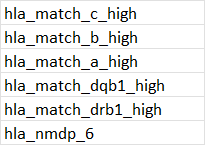

### HLA MATCH C HIGH

In [465]:

print_column_info(df, 'hla_match_c_high')
df = onehotencode_multi(df, 'hla_match_c_high')

Column: hla_match_c_high
Total Entries: 28800
Non-NaN Values: 24180
Missing (NaN) Values: 4620
Missing (NaN) Values %: 16.041666666666668
Unique_values: [nan  2.  1.  0.]

🔹 Processing Column: hla_match_c_high

📊 Mean `efs_time` for each `hla_match_c_high` category:
hla_match_c_high
1    24.023503
2    23.561091
3    21.450292
4    26.532494
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 12.6644, p-value = 0.0000

🔹 Processing Column: hla_match_c_high

📊 Median `efs_time` for each `hla_match_c_high` category:
hla_match_c_high
1    10.0105
2     9.4340
3    11.4460
4    11.7130
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 12.6644, p-value = 0.0000

🔹 Processing Column: hla_match_c_high

📊 Mode `efs_time` for each `hla_match_c_high` category:
hla_match_c_high
1    4.347
2    5.643
3    3.920
4    1.332
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 12.6644, p-value = 0.0000
12.664401742813908 12.664401742813908 12.664401742813908
hla_matc

### HLA MATCH B HIGH

In [466]:
print_column_info(df, 'hla_match_b_high')
df = onehotencode_multi(df, 'hla_match_b_high')

Column: hla_match_b_high
Total Entries: 28800
Non-NaN Values: 24712
Missing (NaN) Values: 4088
Missing (NaN) Values %: 14.194444444444446
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_b_high

📊 Mean `efs_time` for each `hla_match_b_high` category:
hla_match_b_high
1    23.720451
2    21.569220
3    24.018844
4    30.390766
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 16.6752, p-value = 0.0000

🔹 Processing Column: hla_match_b_high

📊 Median `efs_time` for each `hla_match_b_high` category:
hla_match_b_high
1     9.5910
2    10.3980
3     9.8605
4    16.2280
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 16.6752, p-value = 0.0000

🔹 Processing Column: hla_match_b_high

📊 Mode `efs_time` for each `hla_match_b_high` category:
hla_match_b_high
1    5.643
2    5.891
3    3.795
4    3.121
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 16.6752, p-value = 0.0000
16.675212785654065 16.675212785654065 16.675212785654065
hla_matc

### HLA MATCH A HIGH

In [467]:
print_column_info(df, 'hla_match_a_high')
df = onehotencode_multi(df, 'hla_match_a_high')

Column: hla_match_a_high
Total Entries: 28800
Non-NaN Values: 24499
Missing (NaN) Values: 4301
Missing (NaN) Values %: 14.934027777777779
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_a_high

📊 Mean `efs_time` for each `hla_match_a_high` category:
hla_match_a_high
1    23.801038
2    21.333915
3    24.068448
4    27.303079
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.1954, p-value = 0.0000

🔹 Processing Column: hla_match_a_high

📊 Median `efs_time` for each `hla_match_a_high` category:
hla_match_a_high
1     9.7395
2     9.5600
3    10.0620
4    21.4760
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.1954, p-value = 0.0000

🔹 Processing Column: hla_match_a_high

📊 Mode `efs_time` for each `hla_match_a_high` category:
hla_match_a_high
1    5.697
2    3.920
3    5.360
4    0.552
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.1954, p-value = 0.0000
19.19541717973193 19.19541717973193 19.19541717973193
hla_match_a

### HLA_MATCH_DQB1_HIGH

In [468]:
print_column_info(df, 'hla_match_dqb1_high')
df = onehotencode_multi(df, 'hla_match_dqb1_high')

Column: hla_match_dqb1_high
Total Entries: 28800
Non-NaN Values: 23601
Missing (NaN) Values: 5199
Missing (NaN) Values %: 18.052083333333332
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_dqb1_high

📊 Mean `efs_time` for each `hla_match_dqb1_high` category:
hla_match_dqb1_high
1    23.350955
2    22.370738
3    23.896503
4    21.240870
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 3.9790, p-value = 0.0076

🔹 Processing Column: hla_match_dqb1_high

📊 Median `efs_time` for each `hla_match_dqb1_high` category:
hla_match_dqb1_high
1     9.4715
2    12.5125
3     9.4250
4     8.5120
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 3.9790, p-value = 0.0076

🔹 Processing Column: hla_match_dqb1_high

📊 Mode `efs_time` for each `hla_match_dqb1_high` category:
hla_match_dqb1_high
1    5.643
2    3.419
3    5.381
4    0.999
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 3.9790, p-value = 0.0076
3.979040141660308 3.979040141660308 3.

### HLA_MATCH_DRB1_HIGH

In [469]:
print_column_info(df, 'hla_match_drb1_high')
df = onehotencode_multi(df, 'hla_match_drb1_high')


Column: hla_match_drb1_high
Total Entries: 28800
Non-NaN Values: 25448
Missing (NaN) Values: 3352
Missing (NaN) Values %: 11.63888888888889
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_drb1_high

📊 Mean `efs_time` for each `hla_match_drb1_high` category:
hla_match_drb1_high
1    23.162888
2    22.533244
3    25.133636
4    25.294366
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.7213, p-value = 0.0000

🔹 Processing Column: hla_match_drb1_high

📊 Median `efs_time` for each `hla_match_drb1_high` category:
hla_match_drb1_high
1     8.8970
2    14.1520
3    11.6985
4    16.2920
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.7213, p-value = 0.0000

🔹 Processing Column: hla_match_drb1_high

📊 Mode `efs_time` for each `hla_match_drb1_high` category:
hla_match_drb1_high
1    5.643
2    6.331
3    3.640
4    1.066
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.7213, p-value = 0.0000
8.721300056475513 8.721300056475513 8.7

### HLA_NMDP_6

In [470]:
print_column_info(df, 'hla_nmdp_6')
df = onehotencode_multi(df, 'hla_nmdp_6')



Column: hla_nmdp_6
Total Entries: 28800
Non-NaN Values: 24603
Missing (NaN) Values: 4197
Missing (NaN) Values %: 14.572916666666666
Unique_values: [ 6.  5.  3. nan  4.  2.]

🔹 Processing Column: hla_nmdp_6

📊 Mean `efs_time` for each `hla_nmdp_6` category:
hla_nmdp_6
1    23.458685
2    23.620209
3    20.653326
4    24.866401
5    23.992284
6    29.874629
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 15.4101, p-value = 0.0000

🔹 Processing Column: hla_nmdp_6

📊 Median `efs_time` for each `hla_nmdp_6` category:
hla_nmdp_6
1     9.2100
2     9.3290
3    10.2695
4    11.2820
5    17.4620
6    19.1970
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 15.4101, p-value = 0.0000

🔹 Processing Column: hla_nmdp_6

📊 Mode `efs_time` for each `hla_nmdp_6` category:
hla_nmdp_6
1    5.643
2    4.603
3    2.783
4    5.592
5    3.348
6    1.119
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 15.4101, p-value = 0.0000
15.410126218920746 15.410126218920746 1

### RACE_GROUP

In [471]:
print_column_info(df, 'race_group')
df = onehotencode_multi(df, 'race_group')


Column: race_group
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['More than one race' 'Asian' 'White' 'American Indian or Alaska Native'
 'Native Hawaiian or other Pacific Islander' 'Black or African-American']

🔹 Processing Column: race_group

📊 Mean `efs_time` for each `race_group` category:
race_group
1    25.913350
2    22.627618
3    21.826907
4    24.164618
5    23.066415
6    21.812383
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.6051, p-value = 0.0000

🔹 Processing Column: race_group

📊 Median `efs_time` for each `race_group` category:
race_group
1    16.0660
2     8.9745
3     7.9840
4    11.7790
5    10.4320
6     8.5360
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.6051, p-value = 0.0000

🔹 Processing Column: race_group

📊 Mode `efs_time` for each `race_group` category:
race_group
1    4.484
2    5.697
3    3.921
4    4.268
5    2.646
6    6.459
Name: efs_time, dtype: fl

### SEX_MATCH

In [472]:
print_column_info(df, 'sex_match')
df = onehotencode_multi(df, 'sex_match')

Column: sex_match
Total Entries: 28800
Non-NaN Values: 28539
Missing (NaN) Values: 261
Missing (NaN) Values %: 0.9062499999999999
Unique_values: ['M-F' 'F-F' 'F-M' 'M-M' nan]

🔹 Processing Column: sex_match

📊 Mean `efs_time` for each `sex_match` category:
sex_match
1    21.569873
2    25.674560
3    21.268356
4    24.698251
5    24.283958
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 41.7305, p-value = 0.0000

🔹 Processing Column: sex_match

📊 Median `efs_time` for each `sex_match` category:
sex_match
1     8.5050
2    14.0650
3     8.4040
4    13.2735
5    10.8930
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 41.7305, p-value = 0.0000

🔹 Processing Column: sex_match

📊 Mode `efs_time` for each `sex_match` category:
sex_match
1    5.608
2    4.351
3    4.716
4    4.598
5    3.570
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 41.7305, p-value = 0.0000
41.730473471100794 41.730473471100794 41.730473471100794
sex_match is imputed with mo

### TBI_STATUS

In [473]:

print_column_info(df, 'tbi_status')
df = onehotencode_multi(df, 'tbi_status')

Column: tbi_status
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['No TBI' 'TBI +- Other, >cGy' 'TBI + Cy +- Other' 'TBI +- Other, <=cGy'
 'TBI +- Other, unknown dose' 'TBI +- Other, -cGy, fractionated'
 'TBI +- Other, -cGy, single' 'TBI +- Other, -cGy, unknown dose']

🔹 Processing Column: tbi_status

📊 Mean `efs_time` for each `tbi_status` category:
tbi_status
1    23.889855
2    21.630912
3    22.679175
4    19.997420
5    21.399776
6    24.662529
7    21.755410
8    18.232139
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.1950, p-value = 0.0000

🔹 Processing Column: tbi_status

📊 Median `efs_time` for each `tbi_status` category:
tbi_status
1     9.9620
2    14.0875
3     9.7805
4     7.4870
5     8.1670
6    16.2890
7    14.3330
8     9.2840
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.1950, p-value = 0.0000

🔹 Processing Column: tbi_status

📊 Mode `efs_time` for each `tbi_status` c

### GVHD_PROPH

In [474]:
print_column_info(df, 'gvhd_proph')
df = onehotencode_multi(df, 'gvhd_proph')


Column: gvhd_proph
Total Entries: 28800
Non-NaN Values: 28575
Missing (NaN) Values: 225
Missing (NaN) Values %: 0.78125
Unique_values: ['FKalone' 'Other GVHD Prophylaxis' 'Cyclophosphamide alone'
 'FK+ MMF +- others' 'TDEPLETION +- other' 'CSA + MMF +- others(not FK)'
 'CSA + MTX +- others(not MMF,FK)' 'FK+ MTX +- others(not MMF)'
 'Cyclophosphamide +- others' 'CSA alone' nan 'TDEPLETION alone'
 'No GvHD Prophylaxis' 'CDselect alone' 'CDselect +- other'
 'Parent Q = yes, but no agent' 'FK+- others(not MMF,MTX)'
 'CSA +- others(not FK,MMF,MTX)']

🔹 Processing Column: gvhd_proph

📊 Mean `efs_time` for each `gvhd_proph` category:
gvhd_proph
1     29.216817
2     29.340655
3     20.978041
4     21.066720
5     29.726202
6     28.797575
7     29.703772
8     23.874292
9     22.271421
10    29.774252
11    24.073222
12    27.206772
13    26.974679
14    27.916008
15    26.364400
16    18.616806
17     9.985000
18    25.464130
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 26.

### CMV_STATUS

In [475]:
print_column_info(df, 'cmv_status')
df = onehotencode_multi(df, 'cmv_status')


Column: cmv_status
Total Entries: 28800
Non-NaN Values: 28166
Missing (NaN) Values: 634
Missing (NaN) Values %: 2.201388888888889
Unique_values: ['+/+' '-/+' '-/-' nan '+/-']

🔹 Processing Column: cmv_status

📊 Mean `efs_time` for each `cmv_status` category:
cmv_status
1    22.488334
2    20.346151
3    26.070169
4    24.371571
5    28.227179
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 80.5664, p-value = 0.0000

🔹 Processing Column: cmv_status

📊 Median `efs_time` for each `cmv_status` category:
cmv_status
1     9.830
2     7.828
3    12.073
4    15.720
5    20.638
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 80.5664, p-value = 0.0000

🔹 Processing Column: cmv_status

📊 Mode `efs_time` for each `cmv_status` category:
cmv_status
1    5.886
2    5.303
3    6.342
4    2.456
5    5.244
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 80.5664, p-value = 0.0000
80.56643385124953 80.56643385124953 80.56643385124953
cmv_status is imputed with 

### MELPHALAN_DOSE

In [476]:
print_column_info(df, 'melphalan_dose')
df = onehotencode_multi(df, 'melphalan_dose')


Column: melphalan_dose
Total Entries: 28800
Non-NaN Values: 27395
Missing (NaN) Values: 1405
Missing (NaN) Values %: 4.878472222222222
Unique_values: ['N/A, Mel not given' 'MEL' nan]

🔹 Processing Column: melphalan_dose

📊 Mean `efs_time` for each `melphalan_dose` category:
melphalan_dose
1    23.841019
2    22.234406
3    19.775389
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 25.6357, p-value = 0.0000

🔹 Processing Column: melphalan_dose

📊 Median `efs_time` for each `melphalan_dose` category:
melphalan_dose
1     9.870
2     9.449
3    10.834
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 25.6357, p-value = 0.0000

🔹 Processing Column: melphalan_dose

📊 Mode `efs_time` for each `melphalan_dose` category:
melphalan_dose
1    4.347
2    5.298
3    4.188
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 25.6357, p-value = 0.0000
25.63573616835586 25.63573616835586 25.63573616835586
melphalan_dose is imputed with mode !
{1: 'N/A, Mel not giv

### HLA_MATCH_C_LOW

In [477]:
print_column_info(df, 'hla_match_c_low')
df = onehotencode_multi(df, 'hla_match_c_low')


Column: hla_match_c_low
Total Entries: 28800
Non-NaN Values: 26000
Missing (NaN) Values: 2800
Missing (NaN) Values %: 9.722222222222223
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_c_low

📊 Mean `efs_time` for each `hla_match_c_low` category:
hla_match_c_low
1    23.847046
2    21.160919
3    23.357704
4    27.777506
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.2722, p-value = 0.0000

🔹 Processing Column: hla_match_c_low

📊 Median `efs_time` for each `hla_match_c_low` category:
hla_match_c_low
1     9.7175
2    10.0940
3     9.7410
4    17.3440
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.2722, p-value = 0.0000

🔹 Processing Column: hla_match_c_low

📊 Mode `efs_time` for each `hla_match_c_low` category:
hla_match_c_low
1    4.268
2    3.920
3    4.123
4    6.561
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 19.2722, p-value = 0.0000
19.272195881269983 19.272195881269983 19.272195881269983
hla_match_c_low is 

### HLA_MATCH_DQB1_LOW

In [478]:
print_column_info(df, 'hla_match_dqb1_low')
df = onehotencode_multi(df, 'hla_match_dqb1_low')


Column: hla_match_dqb1_low
Total Entries: 28800
Non-NaN Values: 24606
Missing (NaN) Values: 4194
Missing (NaN) Values %: 14.5625
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_dqb1_low

📊 Mean `efs_time` for each `hla_match_dqb1_low` category:
hla_match_dqb1_low
1    23.438103
2    22.139191
3    23.739550
4    22.963835
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 4.5155, p-value = 0.0036

🔹 Processing Column: hla_match_dqb1_low

📊 Median `efs_time` for each `hla_match_dqb1_low` category:
hla_match_dqb1_low
1     9.5960
2    12.0205
3     9.1810
4    12.7240
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 4.5155, p-value = 0.0036

🔹 Processing Column: hla_match_dqb1_low

📊 Mode `efs_time` for each `hla_match_dqb1_low` category:
hla_match_dqb1_low
1    5.608
2    3.575
3    5.381
4    1.489
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 4.5155, p-value = 0.0036
4.515500061044917 4.515500061044917 4.515500061044917
hla_m

### HLA_MATCH_DRB1_LOW

In [479]:
print_column_info(df, 'hla_match_drb1_low')
df = onehotencode_multi(df, 'hla_match_drb1_low')


Column: hla_match_drb1_low
Total Entries: 28800
Non-NaN Values: 26157
Missing (NaN) Values: 2643
Missing (NaN) Values %: 9.177083333333332
Unique_values: [ 2.  1. nan]

🔹 Processing Column: hla_match_drb1_low

📊 Mean `efs_time` for each `hla_match_drb1_low` category:
hla_match_drb1_low
1    23.237198
2    22.617839
3    24.987554
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.9103, p-value = 0.0001

🔹 Processing Column: hla_match_drb1_low

📊 Median `efs_time` for each `hla_match_drb1_low` category:
hla_match_drb1_low
1     9.013
2    14.071
3    10.977
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.9103, p-value = 0.0001

🔹 Processing Column: hla_match_drb1_low

📊 Mode `efs_time` for each `hla_match_drb1_low` category:
hla_match_drb1_low
1    5.643
2    6.331
3    4.347
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 8.9103, p-value = 0.0001
8.910335426372214 8.910335426372214 8.910335426372214
hla_match_drb1_low is imputed with mode !

### DONOR RELATED

In [480]:
print_column_info(df, 'donor_related')
df = onehotencode_multi(df, 'donor_related')

Column: donor_related
Total Entries: 28800
Non-NaN Values: 28642
Missing (NaN) Values: 158
Missing (NaN) Values %: 0.548611111111111
Unique_values: ['Unrelated' 'Related' 'Multiple donor (non-UCB)' nan]

🔹 Processing Column: donor_related

📊 Mean `efs_time` for each `donor_related` category:
donor_related
1    23.088945
2    23.388663
3    20.825026
4    24.411715
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 1.5549, p-value = 0.1981

🔹 Processing Column: donor_related

📊 Median `efs_time` for each `donor_related` category:
donor_related
1     8.6845
2    10.8000
3    10.9715
4    13.4090
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 1.5549, p-value = 0.1981

🔹 Processing Column: donor_related

📊 Mode `efs_time` for each `donor_related` category:
donor_related
1    4.268
2    4.684
3    5.922
4    1.277
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 1.5549, p-value = 0.1981
1.554871482270048 1.554871482270048 1.554871482270048
donor_rel

### HLA_MATCH_A_LOW

In [481]:
print_column_info(df, 'hla_match_a_low')
df = onehotencode_multi(df, 'hla_match_a_low')

Column: hla_match_a_low
Total Entries: 28800
Non-NaN Values: 26410
Missing (NaN) Values: 2390
Missing (NaN) Values %: 8.29861111111111
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_a_low

📊 Mean `efs_time` for each `hla_match_a_low` category:
hla_match_a_low
1    23.919851
2    21.232847
3    24.263876
4    22.126388
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 22.7070, p-value = 0.0000

🔹 Processing Column: hla_match_a_low

📊 Median `efs_time` for each `hla_match_a_low` category:
hla_match_a_low
1     9.6975
2     9.5240
3    10.9615
4    20.2230
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 22.7070, p-value = 0.0000

🔹 Processing Column: hla_match_a_low

📊 Mode `efs_time` for each `hla_match_a_low` category:
hla_match_a_low
1    5.608
2    3.920
3    4.482
4    0.913
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 22.7070, p-value = 0.0000
22.706983820654894 22.706983820654894 22.706983820654894
hla_match_a_low is i

### HLA_MATCH_B_LOW

In [482]:
print_column_info(df, 'hla_match_b_low')
df = onehotencode_multi(df, 'hla_match_b_low')


Column: hla_match_b_low
Total Entries: 28800
Non-NaN Values: 26235
Missing (NaN) Values: 2565
Missing (NaN) Values %: 8.90625
Unique_values: [ 2.  1. nan  0.]

🔹 Processing Column: hla_match_b_low

📊 Mean `efs_time` for each `hla_match_b_low` category:
hla_match_b_low
1    23.499966
2    22.018617
3    24.452713
4    34.400766
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 12.9127, p-value = 0.0000

🔹 Processing Column: hla_match_b_low

📊 Median `efs_time` for each `hla_match_b_low` category:
hla_match_b_low
1     9.331
2    11.394
3    10.586
4    19.576
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 12.9127, p-value = 0.0000

🔹 Processing Column: hla_match_b_low

📊 Mode `efs_time` for each `hla_match_b_low` category:
hla_match_b_low
1    5.589
2    5.615
3    4.482
4    1.165
Name: efs_time, dtype: float64

📈 ANOVA Results: F-statistic = 12.9127, p-value = 0.0000
12.912724154380548 12.912724154380548 12.912724154380548
hla_match_b_low is imputed with m

## NOMINAL VALUES WITH NO NAN

### PRIM DISEASE HCT

In [483]:
print_column_info(df, 'prim_disease_hct')
df_encoded = pd.get_dummies(df, columns=['prim_disease_hct'], prefix='disease', drop_first=True)


Column: prim_disease_hct
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['IEA' 'AML' 'HIS' 'ALL' 'MPN' 'IIS' 'Solid tumor' 'Other leukemia' 'PCD'
 'IPA' 'IMD' 'MDS' 'NHL' 'SAA' 'AI' 'CML' 'Other acute leukemia' 'HD']


### GRAFT TYPE

In [484]:
print_column_info(df, 'graft_type')
df_encoded = pd.get_dummies(df, columns=['graft_type'], prefix='disease', drop_first=True)

Column: graft_type
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['Bone marrow' 'Peripheral blood']


### PROD_TYPE

In [485]:
print_column_info(df, 'prod_type')
df_encoded = pd.get_dummies(df, columns=['prod_type'], prefix='disease', drop_first=True)

Column: prod_type
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['BM' 'PB']


### VENT HIST

In [486]:
print_column_info(df, 'vent_hist')
df['vent_hist'] = df['vent_hist'].fillna('vent_hist_Unknown')
df_encoded = pd.get_dummies(df, columns=['vent_hist'], prefix='vent', drop_first=True)


Column: vent_hist
Total Entries: 28800
Non-NaN Values: 28541
Missing (NaN) Values: 259
Missing (NaN) Values %: 0.8993055555555556
Unique_values: ['No' 'Yes' nan]


### IN_VIVO_TCD

In [487]:
print_column_info(df, 'in_vivo_tcd')
df['in_vivo_tcd'] = df['in_vivo_tcd'].fillna('in_vivo_tcd_Unknown')
df_encoded = pd.get_dummies(df, columns=['in_vivo_tcd'], prefix='in_vivo', drop_first=True)

Column: in_vivo_tcd
Total Entries: 28800
Non-NaN Values: 28575
Missing (NaN) Values: 225
Missing (NaN) Values %: 0.78125
Unique_values: ['Yes' 'No' nan]


##FINAL PREPROCESSED DATA

In [488]:
for col in df.columns:
  print(print_column_info(df,col))


Column: diabetes
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['No' 'Yes' 'Not done' 'Missing']
None
Column: graft_type
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['Bone marrow' 'Peripheral blood']
None
Column: vent_hist
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['No' 'Yes' 'vent_hist_Unknown']
None
Column: prim_disease_hct
Total Entries: 28800
Non-NaN Values: 28800
Missing (NaN) Values: 0
Missing (NaN) Values %: 0.0
Unique_values: ['IEA' 'AML' 'HIS' 'ALL' 'MPN' 'IIS' 'Solid tumor' 'Other leukemia' 'PCD'
 'IPA' 'IMD' 'MDS' 'NHL' 'SAA' 'AI' 'CML' 'Other acute leukemia' 'HD']
None
Column: tce_imm_match
Total Entries: 28800
Non-NaN Values: 17667
Missing (NaN) Values: 11133
Missing (NaN) Values %: 38.65625
Unique_values: [nan 'P/P' 'G/B' 'H/B' 'G/G' 'P/H' 'P/B' 'H/H' 'P/G']
None
Column: prod_t

### HLA MATCH C HIGH

#XGBOOST

In [492]:

'''
 # Ensure target columns exist and are correctly formatted
data["efs"] = data["efs"].astype(bool)
data["efs_time"] = pd.to_numeric(data["efs_time"], errors="coerce")

# Drop rows with missing target values
data = data.dropna(subset=["efs", "efs_time"])

# Define features and target
X = data.drop(columns=[ "efs", "efs_time"])
y = Surv.from_dataframe(event="efs", time="efs_time", data=data)
'''
 # Ensure target columns exist and are correctly formatted
df["efs"] = data["efs"].astype(bool)
df["efs_time"] = pd.to_numeric(df["efs_time"], errors="coerce")

# Drop rows with missing target values
df = df.dropna(subset=["efs", "efs_time"])

# Define features and target
X = df.drop(columns=[ "efs", "efs_time"])
y = Surv.from_dataframe(event="efs", time="efs_time", data=data)






# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=["object"]).columns
numerical_columns = X.select_dtypes(include=["number"]).columns

# Preprocessing: One-hot encode categorical variables, scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ]
)

X_preprocessed = preprocessor.fit_transform(X)
print(type(X_preprocessed))
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42
)

# Prepare target arrays for XGBoost
y_train_time = y_train['efs_time'] # Access 'time' field of structured array
y_train_event = y_train['efs'] # Access 'event' field of structured array

y_test_time = y_test['efs_time'] # Access 'time' field of structured array
y_test_event = y_test['efs'] # Access 'event' field of structured array

# Train Gradient Boosted Survival Trees
gbst = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=15,
    random_state=42
)
gbst.fit(X_train,y_train_event)

# Evaluate model
risk_scores = gbst.predict(X_test)

#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test_event,risk_scores)

c_index = concordance_index_censored(y_test_event, y_test_time, risk_scores)
print(f"Concordance Index: {c_index[0]:.4f}")


def get_xgb_imp(model, feature_names):
    importance = model.feature_importances_
    return dict(zip(feature_names, importance))
#get_xgb_imp(gbst, df.columns.to_list())

# Define the number of top features you want to keep:
n = 59

# Sort the dictionary items by their importance value (in descending order)
sorted_features = sorted(get_xgb_imp(gbst, df.columns.to_list()).items(), key=lambda item: item[1], reverse=True)

# Extract the top n features
top_n_features = sorted_features[:n]

# Convert the list of tuples back to a dictionary (optional)
top_n_features_dict = dict(top_n_features)

# Display the top n features
print("Top", n, "features by importance:")
for feature, importance in top_n_features:
    print(f"{feature}: {importance}")



<class 'numpy.ndarray'>
Concordance Index: 0.6859
Top 59 features by importance:
age_at_hct: 0.13891948759555817
ethnicity: 0.09591428935527802
prim_disease_hct: 0.05612603574991226
efs_time: 0.040152713656425476
tce_imm_match: 0.021716685965657234
hepatic_mild_Missing: 0.016942670568823814
obesity_Yes: 0.016709886491298676
psych_disturb_binary: 0.014250141568481922
hepatic_mild_Yes: 0.013936777599155903
pulm_moderate_Not done: 0.013840570114552975
mrd_hct_1.0: 0.013695016503334045
donor_age: 0.013525629416108131
diabetes_binary: 0.012868992984294891
hepatic_severe_Not done: 0.012201791629195213
hla_low_res_10: 0.01213032379746437
peptic_ulcer_No: 0.011961730197072029
hepatic_severe_No: 0.011870190501213074
pulm_moderate_No: 0.011845557019114494
hla_high_res_6: 0.01181686669588089
vent_hist: 0.011815627105534077
rheum_issue_binary: 0.011472608894109726
diabetes_No: 0.010818804614245892
hepatic_mild_Not done: 0.010713770054280758
psych_disturb_Not done: 0.010466459207236767
psych_distur

In [490]:
from numpy import array

In [491]:
df.columns.to_list()

['diabetes',
 'graft_type',
 'vent_hist',
 'prim_disease_hct',
 'tce_imm_match',
 'prod_type',
 'cyto_score_detail',
 'ethnicity',
 'in_vivo_tcd',
 'donor_age',
 'age_at_hct',
 'efs',
 'efs_time',
 'hla_low_res_6',
 'hla_low_res_8',
 'hla_low_res_10',
 'hla_high_res_6',
 'hla_high_res_8',
 'hla_high_res_10',
 'dri_score',
 'karnofsky_score',
 'cyto_score',
 'comorbidity_score',
 'conditioning_intensity',
 'psych_disturb_binary',
 'psych_disturb_Missing',
 'psych_disturb_No',
 'psych_disturb_Not done',
 'psych_disturb_Yes',
 'diabetes_binary',
 'diabetes_Missing',
 'diabetes_No',
 'diabetes_Not done',
 'diabetes_Yes',
 'hepatic_severe_binary',
 'hepatic_severe_Missing',
 'hepatic_severe_No',
 'hepatic_severe_Not done',
 'hepatic_severe_Yes',
 'pulm_severe_binary',
 'pulm_severe_Missing',
 'pulm_severe_No',
 'pulm_severe_Not done',
 'pulm_severe_Yes',
 'obesity_binary',
 'obesity_Missing',
 'obesity_No',
 'obesity_Not done',
 'obesity_Yes',
 'arrhythmia_binary',
 'arrhythmia_Missing',
 '

# ADAboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


# 5. Handle missing values using median imputation
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)




# Apply preprocessing
X = data.drop(columns=["efs_time", "efs"])  # Drop target columns
y = data[["efs", "efs_time"]]  # Survival outcome (Event + Time)

X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed=np.nan_to_num(X_preprocessed, nan=0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Extract event and time components
y_train_event = y_train['efs'].astype(bool)  # ✅ Convert to boolean
y_test_event = y_test['efs'].astype(bool)  # ✅ Convert to boolean

# Train AdaBoost Classifier
base_learner = DecisionTreeClassifier(max_depth=7)  # Weak learner (stump)
adaboost = AdaBoostClassifier(estimator=base_learner, n_estimators=100, learning_rate=0.1, algorithm='SAMME', random_state=42)

'''

# Fit model
adaboost.fit(X_train, y_train_event)

# ✅ Use `predict_proba()` to get risk scores instead of `predict()`
risk_scores = adaboost.predict_proba(X_test)[:, 1]  # Probability of class 1 (Event)

# Evaluate model using Concordance Index
c_index = concordance_index_censored(y_test_event, y_test["efs_time"], risk_scores)
print(f"Concordance Index: {c_index[0]:.4f}")
'''

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of weak learners
    "learning_rate": [0.01, 0.1, 0.5, 1.0],  # Learning rate
    "estimator__max_depth": [1, 2, 3]  # Depth of weak learners
}

# Grid search with cross-validation
grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train_event)

# Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train AdaBoost with best parameters
best_model = grid_search.best_estimator_

# Predict risk scores
risk_scores = best_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Event)

# Evaluate model using Concordance Index
c_index = concordance_index_censored(y_test_event, y_test["efs_time"], risk_scores)
print(f"Optimized Concordance Index: {c_index[0]:.4f}")

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'N/A - non-malignant indication'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sksurv.metrics import concordance_index_censored

# Get feature names from One-Hot Encoder
encoded_feature_names = preprocessor.get_feature_names_out()

# Get feature importances
importances = best_model.feature_importances_

# Create DataFrame of feature importance
feature_importance_df = pd.DataFrame({"Feature": encoded_feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(30)  # Show top 20

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features in AdaBoost")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()